<a href="https://colab.research.google.com/github/MNiharika20/Niharika2098/blob/main/Week_2_Project_Data_Wrangling_%26_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Loading & Initial** **Inspection**






In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load each dataset by its file name (since they are in the same directory)
sales_data = pd.read_csv('sales_data.csv')
product_info = pd.read_csv('product_info.csv')
customer_info = pd.read_csv('customer_info.csv')

# Display the first 5 rows to confirm they loaded
print("Sales Data:")
print(sales_data.head())

print("\nProduct Info:")
print(product_info.head())

print("\nCustomer Info:")
print(customer_info.head())

In [ ]:
# Deep copy the DataFrames to work on them
sales_data_clean = sales_data.copy()
product_info_clean = product_info.copy()
customer_info_clean = customer_info.copy()

# ---- 1. Cleaning sales_data.csv ----

# Handle missing values: Fill discount_applied with 0.0
sales_data_clean['discount_applied'] = sales_data_clean['discount_applied'].fillna(0.0)

# Identify missing values
print("Missing values in sales_data before handling other NaNs:")
print(sales_data_clean.isnull().sum())

# Drop rows where key identifiers are missing
sales_data_clean.dropna(subset=['order_id', 'customer_id', 'product_id'], inplace=True)

# Standardize text formatting
sales_data_clean['delivery_status'] = sales_data_clean['delivery_status'].str.strip().str.title()
sales_data_clean['region'] = sales_data_clean['region'].str.strip().str.title()
sales_data_clean['payment_method'] = sales_data_clean['payment_method'].str.strip().str.title()

# Convert quantity to numeric, coerce errors to NaN and drop those rows
sales_data_clean['quantity'] = pd.to_numeric(sales_data_clean['quantity'], errors='coerce')
sales_data_clean.dropna(subset=['quantity'], inplace=True)

# Convert order_date to datetime
sales_data_clean['order_date'] = pd.to_datetime(sales_data_clean['order_date'], format='%d-%m-%Y')

# Remove duplicates based on order_id
print(f"\nNumber of rows in sales_data before removing duplicates: {len(sales_data_clean)}")
sales_data_clean.drop_duplicates(subset=['order_id'], inplace=True)
print(f"Number of rows in sales_data after removing duplicates: {len(sales_data_clean)}")

# Validate numeric columns
sales_data_clean = sales_data_clean[sales_data_clean['quantity'] >= 0]
sales_data_clean = sales_data_clean[sales_data_clean['unit_price'] >= 0]
sales_data_clean = sales_data_clean[sales_data_clean['discount_applied'] >= 0]


# ---- 2. Cleaning product_info.csv ----

# Convert launch_date to datetime
product_info_clean['launch_date'] = pd.to_datetime(product_info_clean['launch_date'], format='%d-%m-%y')


# ---- 3. Cleaning customer_info.csv ----

# Standardize text formatting
customer_info_clean['gender'] = customer_info_clean['gender'].str.strip().str.title()
customer_info_clean['region'] = customer_info_clean['region'].str.strip().str.title()
customer_info_clean['loyalty_tier'] = customer_info_clean['loyalty_tier'].str.strip().str.title()

# Handle missing values: Fill appropriate columns with 'Unknown'
print("\nMissing values in customer_info before handling:")
print(customer_info_clean.isnull().sum())

# Fill missing categorical values with 'Unknown'
for col in ['gender', 'region', 'loyalty_tier']:
    customer_info_clean[col] = customer_info_clean[col].fillna('Unknown')

# Drop rows where key identifiers are missing
customer_info_clean.dropna(subset=['customer_id'], inplace=True)

# Convert signup_date to datetime
customer_info_clean['signup_date'] = pd.to_datetime(customer_info_clean['signup_date'], format='%d-%m-%y')

# Remove duplicates based on customer_id
print(f"\nNumber of rows in customer_info before removing duplicates: {len(customer_info_clean)}")
customer_info_clean.drop_duplicates(subset=['customer_id'], inplace=True)
print(f"Number of rows in customer_info after removing duplicates: {len(customer_info_clean)}")

# Display info and head of cleaned DataFrames
print("\n--- Cleaned sales_data info ---")
print(sales_data_clean.info())
print("\n--- Cleaned product_info info ---")
print(product_info_clean.info())
print("\n--- Cleaned customer_info info ---")
print(customer_info_clean.info())

# Save the cleaned dataframes to CSV
sales_data_clean.to_csv('sales_data_cleaned.csv', index=False)
product_info_clean.to_csv('product_info_cleaned.csv', index=False)
customer_info_clean.to_csv('customer_info_cleaned.csv', index=False)

In [ ]:
# Merge sales_data_clean with product_info_clean
merged_df = pd.merge(sales_data_clean, product_info_clean, on='product_id', how='left')

# Then merge the result with customer_info_clean
merged_df = pd.merge(merged_df, customer_info_clean, on='customer_id', how='left')

# Drop duplicated columns after merge
merged_df.drop(columns=['region_y'], inplace=True)
merged_df.rename(columns={'region_x': 'region'}, inplace=True)

# Inspect merged_df using .info() and .head()
print("Merged DataFrame Info:")
print(merged_df.info())
print("\nMerged DataFrame Head:")
print(merged_df.head())

# Save the merged dataframe to a CSV file
merged_df.to_csv('merged_df.csv', index=False)

In [ ]:
# Load the merged DataFrame # example code
merged_df = pd.read_csv('merged_df.csv', parse_dates=['order_date', 'launch_date', 'signup_date'])

# ---- Feature Engineering ----

# 1. Calculate 'revenue'
merged_df['revenue'] = merged_df['quantity'] * merged_df['unit_price'] * (1 - merged_df['discount_applied'])

# 2. Extract 'order_week' from 'order_date'
# Handle missing values in 'order_date' before extracting the week
merged_df['order_date_filled'] = merged_df['order_date'].fillna(pd.Timestamp('1900-01-01'))
merged_df['order_week'] = merged_df['order_date_filled'].dt.isocalendar().week.astype('Int64')
merged_df.drop(columns=['order_date_filled'], inplace=True)

# 3. Categorise 'price_band' using pd.cut()
import numpy as np # Import numpy here
price_bins = [-np.inf, 15, 30, np.inf]
price_labels = ['Low', 'Medium', 'High']
merged_df['price_band'] = pd.cut(merged_df['unit_price'], bins=price_bins, labels=price_labels, right=False)

# 4. Calculate 'days_to_order'
# Handle potential NaT values in 'order_date' or 'launch_date'
merged_df['days_to_order'] = (merged_df['order_date'] - merged_df['launch_date']).dt.days

# 5. Extract 'email_domain'
merged_df['email_domain'] = merged_df['email'].str.split('@').str[1]

# 6. Create 'is_late' boolean column
# Handle potential missing values in 'delivery_status'
merged_df['is_late'] = merged_df['delivery_status'].fillna('Unknown') == 'Delayed'

# Display the updated DataFrame
print("DataFrame with new features:")
display(merged_df.head())
print("\nDataFrame Info with new features:")
print(merged_df.info())

# Save the DataFrame with new features
merged_df.to_csv('merged_df_with_features.csv', index=False)

In [ ]:
# Load the merged DataFrame
merged_df = pd.read_csv('merged_df.csv', parse_dates=['order_date', 'launch_date', 'signup_date'])

# ---- Feature Engineering ----

# 1. Calculate 'revenue'
merged_df['revenue'] = merged_df['quantity'] * merged_df['unit_price'] * (1 - merged_df['discount_applied'])

# 2. Extract 'order_week' from 'order_date'
# Handle missing dates before extraction
merged_df['order_date_temp'] = merged_df['order_date'].fillna(pd.to_datetime('1900-01-01'))
merged_df['order_week'] = merged_df['order_date_temp'].dt.isocalendar().week
merged_df['order_week'] = merged_df['order_week'].astype(int)
merged_df.drop(columns=['order_date_temp'], inplace=True)

# 3. Categorise 'price_band' using pd.cut()
price_bins = [-np.inf, 15, 30, np.inf]
price_labels = ['Low', 'Medium', 'High']
merged_df['price_band'] = pd.cut(merged_df['unit_price'], bins=price_bins, labels=price_labels, right=False)

# 4. Calculate 'days_to_order'
# Handle missing dates
merged_df['days_to_order'] = (merged_df['order_date'] - merged_df['launch_date']).dt.days

# 5. Extract 'email_domain'
merged_df['email_domain'] = merged_df['email'].str.split('@').str[1]

# 6. Create 'is_late' boolean column
merged_df['is_late'] = merged_df['delivery_status'] == 'Delayed'

# Display the updated DataFrame
print("DataFrame with new features:")
print(merged_df.head())
print("\nDataFrame Info with new features:")
print(merged_df.info())

# Save the DataFrame with new features
merged_df.to_csv('merged_df_with_features.csv', index=False)

In [ ]:
# Load the DataFrame with new features
merged_df = pd.read_csv('merged_df_with_features.csv', parse_dates=['order_date', 'launch_date', 'signup_date'])

# ---- 1. Weekly revenue trends by region ----
weekly_revenue = merged_df.groupby(['order_week', 'region'])['revenue'].sum().unstack(fill_value=0)
print("Weekly Revenue Trends by Region:")
print(weekly_revenue.to_markdown(numalign="left", stralign="left"))
weekly_revenue.to_csv('weekly_revenue_trends.csv')

# ---- 2. Product category performance ----
category_performance = merged_df.groupby('category').agg(
    total_revenue=('revenue', 'sum'),
    total_quantity=('quantity', 'sum'),
    avg_discount=('discount_applied', 'mean')
).sort_values(by='total_revenue', ascending=False)
print("\nProduct Category Performance:")
print(category_performance.to_markdown(numalign="left", stralign="left"))
category_performance.to_csv('category_performance.csv')

# ---- 3. Customer behaviour by loyalty_tier and signup_month ----
merged_df['signup_month'] = merged_df['signup_date'].dt.month
customer_behavior = merged_df.groupby(['loyalty_tier', 'signup_month']).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('revenue', 'sum')
).sort_values(by=['loyalty_tier', 'signup_month'])
print("\nCustomer Behavior by Loyalty Tier and Signup Month:")
print(customer_behavior.to_markdown(numalign="left", stralign="left"))
customer_behavior.to_csv('customer_behavior.csv')

# ---- 4. Delivery performance by region and price_band ----
delivery_performance = merged_df.groupby(['region', 'price_band'])['delivery_status'].value_counts().unstack(fill_value=0)
print("\nDelivery Performance by Region and Price Band:")
print(delivery_performance.to_markdown(numalign="left", stralign="left"))
delivery_performance.to_csv('delivery_performance.csv')

# ---- 5. Preferred payment methods by loyalty_tier ----
payment_methods = merged_df.groupby(['loyalty_tier', 'payment_method'])['order_id'].count().unstack(fill_value=0)
print("\nPreferred Payment Methods by Loyalty Tier:")
print(payment_methods.to_markdown(numalign="left", stralign="left"))
payment_methods.to_csv('preferred_payment_methods.csv')

In [ ]:
# Load the DataFrame with new features
merged_df = pd.read_csv('merged_df_with_features.csv', parse_dates=['order_date', 'launch_date', 'signup_date'])

# ---- cleaning step ----
# Correct inconsistent loyalty_tier values
merged_df['loyalty_tier'] = merged_df['loyalty_tier'].replace({'Brnze': 'Bronze', 'Gld': 'Gold', 'Sllver': 'Silver'})

# Correct inconsistent region values
merged_df['region'] = merged_df['region'].replace({'Nrth': 'North'})

# Correct inconsistent delivery_status values
merged_df['delivery_status'] = merged_df['delivery_status'].replace({'Delrd': 'Delivered', 'Delyd': 'Delayed'})

# Correct inconsistent payment_method values
merged_df['payment_method'] = merged_df['payment_method'].replace({'Bank Transfr': 'Bank Transfer'})

# ---- Re-create features to be safe ----
merged_df['revenue'] = merged_df['quantity'] * merged_df['unit_price'] * (1 - merged_df['discount_applied'])
merged_df['order_date_temp'] = merged_df['order_date'].fillna(pd.to_datetime('1900-01-01'))
merged_df['order_week'] = merged_df['order_date_temp'].dt.isocalendar().week
merged_df['order_week'] = merged_df['order_week'].astype(int)
merged_df.drop(columns=['order_date_temp'], inplace=True)
merged_df['days_to_order'] = (merged_df['order_date'] - merged_df['launch_date']).dt.days
merged_df['email_domain'] = merged_df['email'].str.split('@').str[1]
merged_df['is_late'] = merged_df['delivery_status'] == 'Delayed'
merged_df['price_band'] = pd.cut(merged_df['unit_price'], bins=[-np.inf, 15, 30, np.inf], labels=['Low', 'Medium', 'High'], right=False)

# ---- create summary tables ----
# 1. Weekly revenue trends by region
weekly_revenue = merged_df.groupby(['order_week', 'region'])['revenue'].sum().unstack(fill_value=0)
print("Weekly Revenue Trends by Region (Corrected):")
print(weekly_revenue.to_markdown(numalign="left", stralign="left"))
weekly_revenue.to_csv('weekly_revenue_trends_corrected.csv')

# 2. Product category performance
category_performance = merged_df.groupby('category').agg(
    total_revenue=('revenue', 'sum'),
    total_quantity=('quantity', 'sum'),
    avg_discount=('discount_applied', 'mean')
).sort_values(by='total_revenue', ascending=False)
print("\nProduct Category Performance (Corrected):")
print(category_performance.to_markdown(numalign="left", stralign="left"))
category_performance.to_csv('category_performance_corrected.csv')

# 3. Customer behaviour by loyalty_tier and signup_month
merged_df['signup_month'] = merged_df['signup_date'].dt.month
customer_behavior = merged_df.groupby(['loyalty_tier', 'signup_month']).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('revenue', 'sum')
).sort_values(by=['loyalty_tier', 'signup_month'])
print("\nCustomer Behavior by Loyalty Tier and Signup Month (Corrected):")
print(customer_behavior.to_markdown(numalign="left", stralign="left"))
customer_behavior.to_csv('customer_behavior_corrected.csv')

# 4. Delivery performance by region and price_band
delivery_performance = merged_df.groupby(['region', 'price_band'])['delivery_status'].value_counts().unstack(fill_value=0)
print("\nDelivery Performance by Region and Price Band (Corrected):")
print(delivery_performance.to_markdown(numalign="left", stralign="left"))
delivery_performance.to_csv('delivery_performance_corrected.csv')

# 5. Preferred payment methods by loyalty_tier
payment_methods = merged_df.groupby(['loyalty_tier', 'payment_method'])['order_id'].count().unstack(fill_value=0)
print("\nPreferred Payment Methods by Loyalty Tier (Corrected):")
print(payment_methods.to_markdown(numalign="left", stralign="left"))
payment_methods.to_csv('preferred_payment_methods_corrected.csv')

# Save the final cleaned and feature-engineered DataFrame for visualizations
merged_df.to_csv('merged_df_final.csv', index=False)

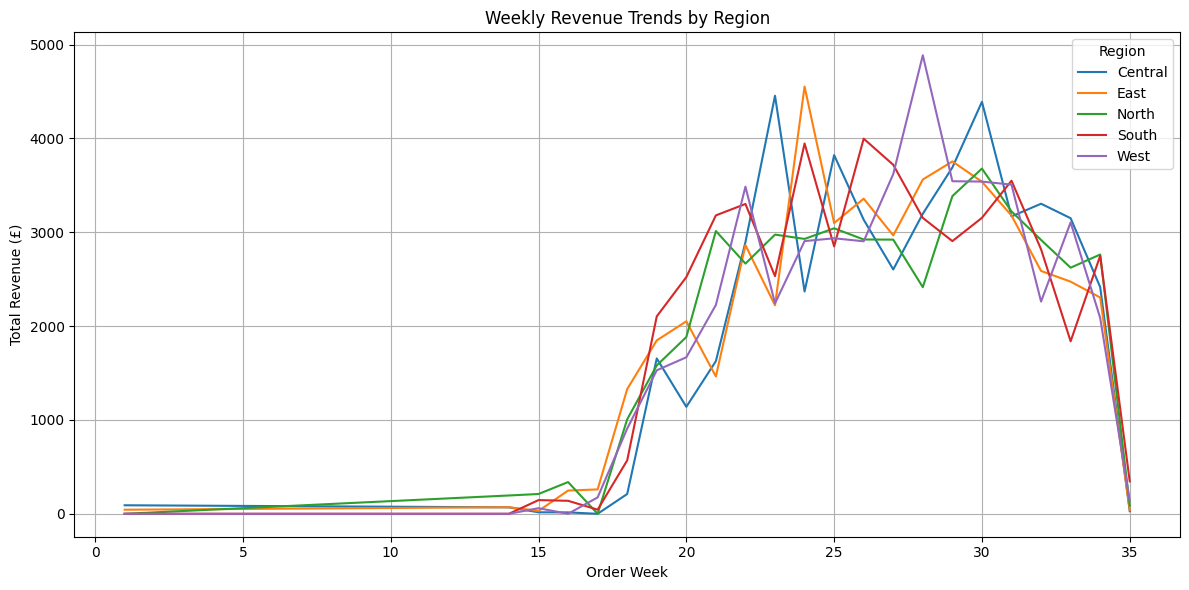

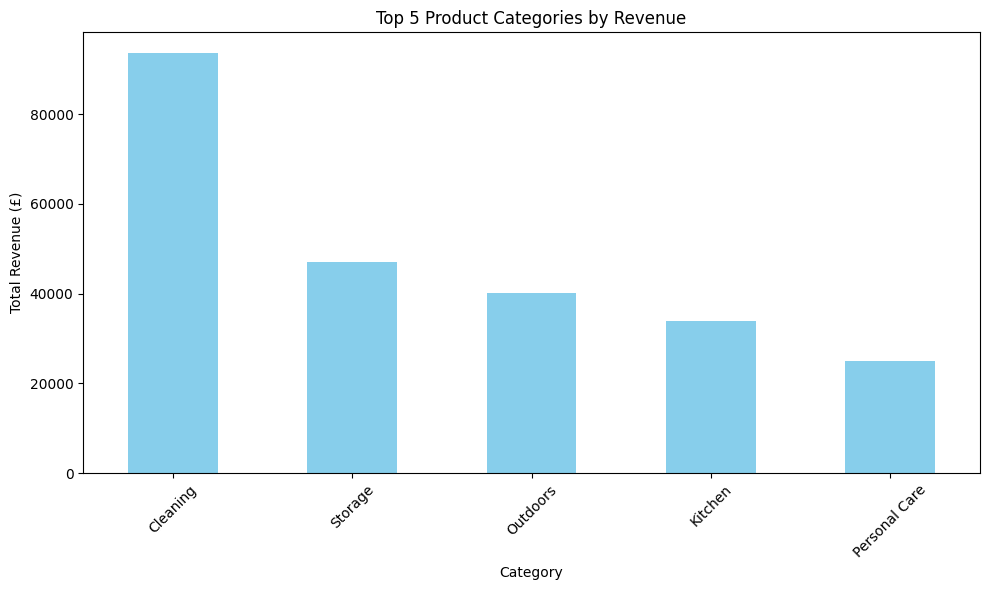

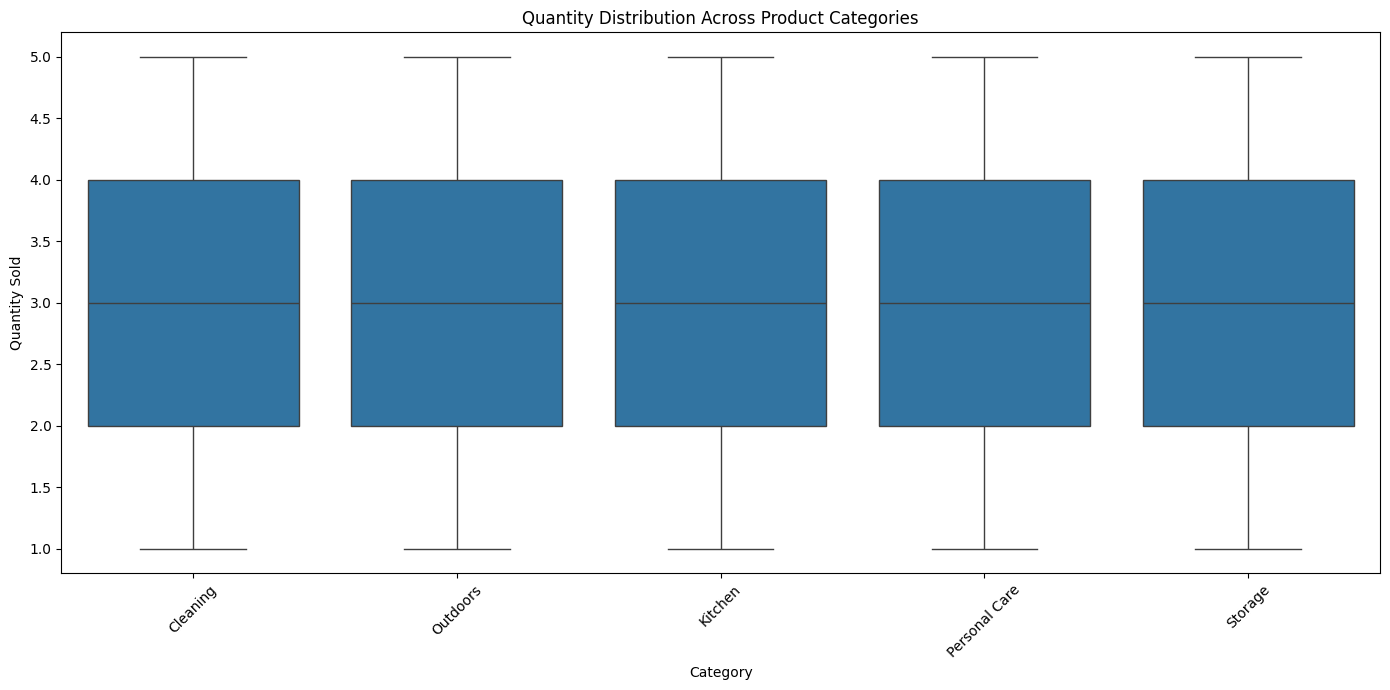

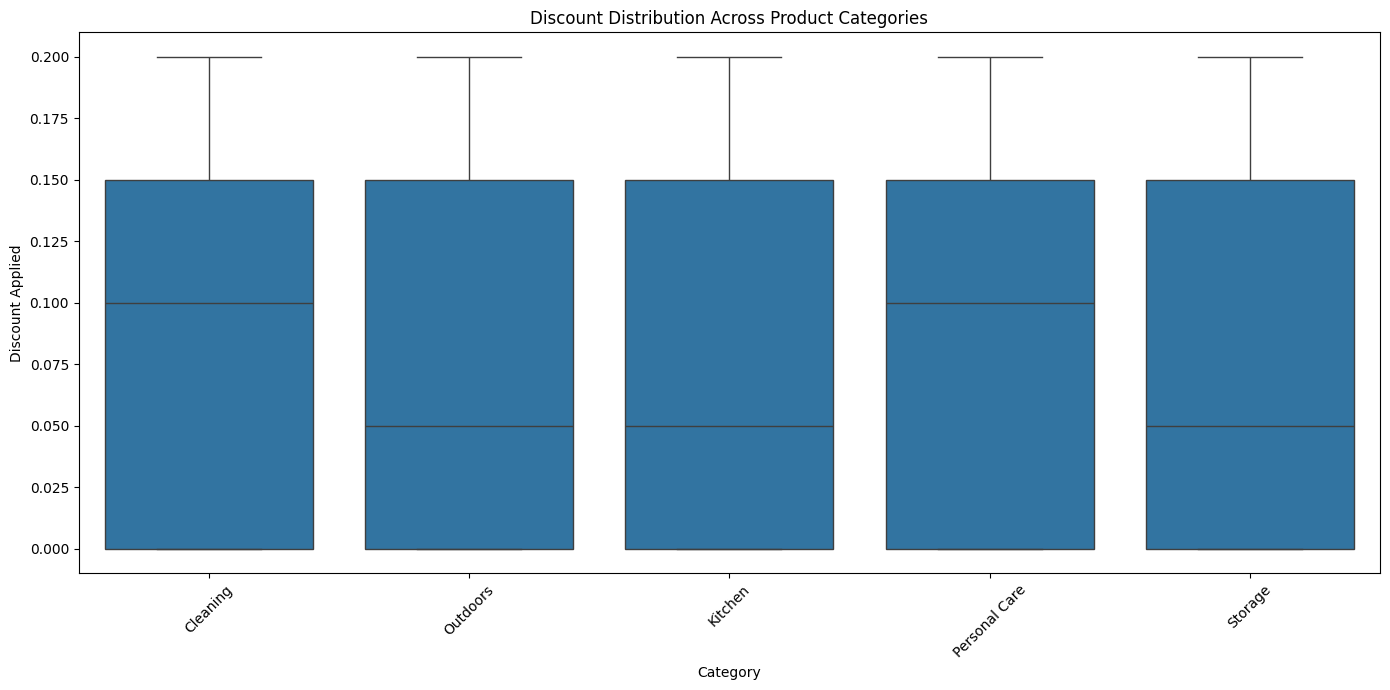

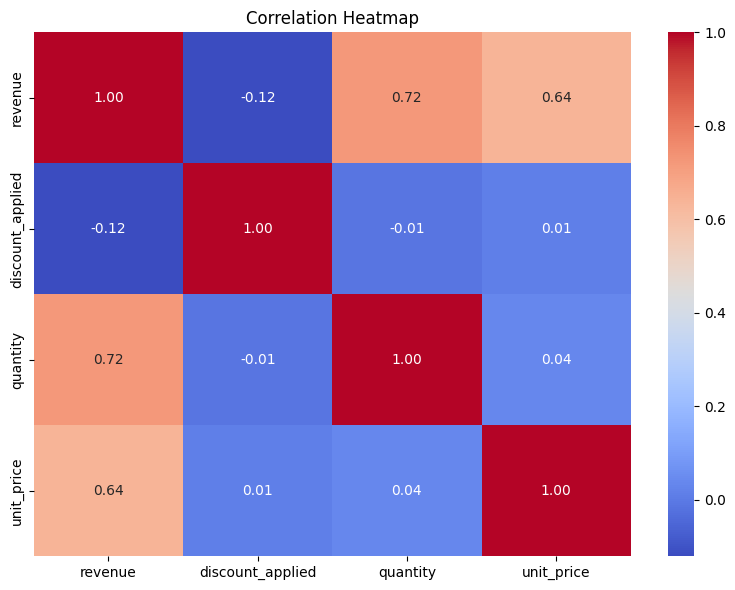

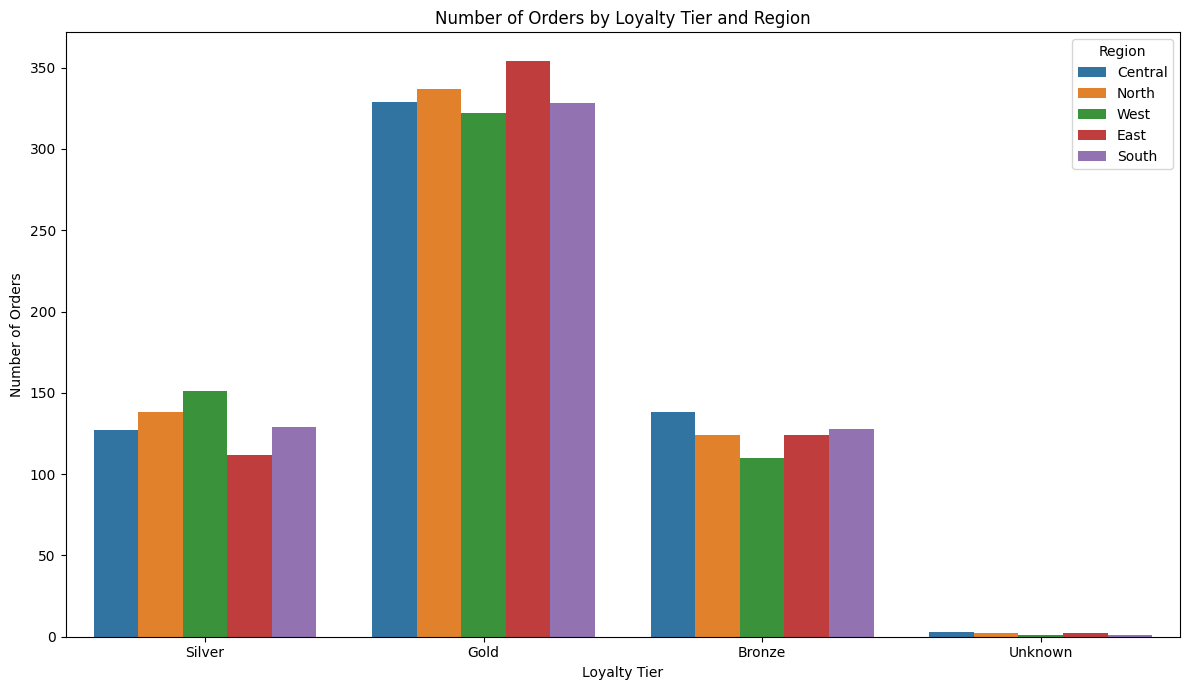

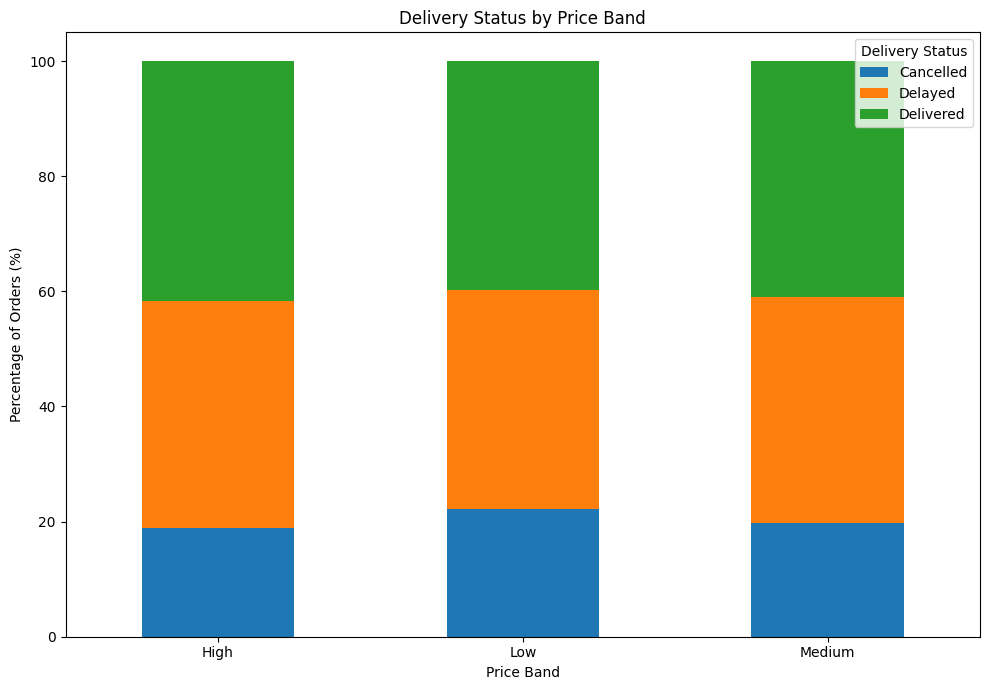

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned DataFrame
merged_df = pd.read_csv('merged_df_final.csv')
merged_df.head()
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])
merged_df['launch_date'] = pd.to_datetime(merged_df['launch_date'])
merged_df['signup_date'] = pd.to_datetime(merged_df['signup_date'])

# ---- 1. Line plot - weekly revenue trends by region ----
plt.figure(figsize=(12, 6))
weekly_revenue = merged_df.groupby(['order_week', 'region'])['revenue'].sum().unstack(fill_value=0)
weekly_revenue.plot(kind='line', ax=plt.gca())
plt.title('Weekly Revenue Trends by Region')
plt.xlabel('Order Week')
plt.ylabel('Total Revenue (£)')
plt.legend(title='Region')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 2. Bar chart - top 5 categories by revenue ----
plt.figure(figsize=(10, 6))
category_revenue = merged_df.groupby('category')['revenue'].sum().nlargest(5).sort_values(ascending=False)
category_revenue.plot(kind='bar', color='skyblue')
plt.title('Top 5 Product Categories by Revenue')
plt.xlabel('Category')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- 3. Boxplot - quantity across categories ----
plt.figure(figsize=(14, 7))
sns.boxplot(x='category', y='quantity', data=merged_df)
plt.title('Quantity Distribution Across Product Categories')
plt.xlabel('Category')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot for discount distribution
plt.figure(figsize=(14, 7))
sns.boxplot(x='category', y='discount_applied', data=merged_df)
plt.title('Discount Distribution Across Product Categories')
plt.xlabel('Category')
plt.ylabel('Discount Applied')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- 4. Heatmap - correlation ----
plt.figure(figsize=(8, 6))
corr_matrix = merged_df[['revenue', 'discount_applied', 'quantity', 'unit_price']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# ---- 5. Countplot - orders by loyalty tier (with hue = region) ----
plt.figure(figsize=(12, 7))
sns.countplot(x='loyalty_tier', hue='region', data=merged_df)
plt.title('Number of Orders by Loyalty Tier and Region')
plt.xlabel('Loyalty Tier')
plt.ylabel('Number of Orders')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

# ---- 6. Stacked bar chart - delivery status by price band ----
plt.figure(figsize=(10, 7))
delivery_by_price = merged_df.groupby(['price_band', 'delivery_status']).size().unstack(fill_value=0)
delivery_by_price_normalized = delivery_by_price.div(delivery_by_price.sum(axis=1), axis=0) * 100
delivery_by_price_normalized.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Delivery Status by Price Band')
plt.xlabel('Price Band')
plt.ylabel('Percentage of Orders (%)')
plt.xticks(rotation=0)
plt.legend(title='Delivery Status')
plt.tight_layout()
plt.show()

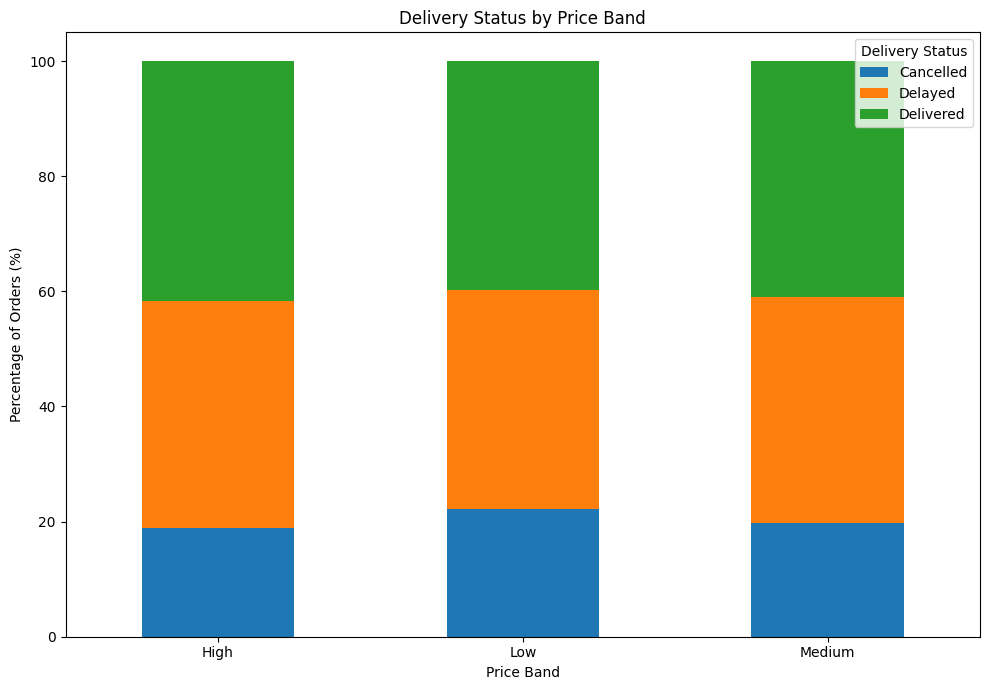

In [51]:
# ---- 6. Stacked bar - delivery status by price band ---- # example chart checking if its working or not.
plt.figure(figsize=(10, 7))
delivery_by_price = merged_df.groupby(['price_band', 'delivery_status']).size().unstack(fill_value=0)
delivery_by_price_normalized = delivery_by_price.div(delivery_by_price.sum(axis=1), axis=0) * 100
delivery_by_price_normalized.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Delivery Status by Price Band')
plt.xlabel('Price Band')
plt.ylabel('Percentage of Orders (%)')
plt.xticks(rotation=0)
plt.legend(title='Delivery Status')
plt.tight_layout()
plt.savefig('delivery_status_by_price_band.png')
plt.show()

In [50]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

TypeError: 'NoneType' object is not subscriptable

After uploading, you can load the data into a pandas DataFrame:

In [ ]:
import pandas as pd

# Assuming the uploaded file is named 'sales_data.csv'
sales_data = pd.read_csv('sales_data.csv')

# Display the first few rows to confirm it loaded correctly
display(sales_data.head())